### QOSE: MPI and SV1 parallelization on AWS 

In order to make our algorithm scalable and utilize the complete software stack as efficiently as possible, we parallelize the concurrent evaluation of circuits in our search tree as well as allowing for fast evaluation of quantum gradients using the SV1 Braket simulator.

In [2]:
%config Completer.use_jedi = False
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

Here, we briefly demo the parallel version of QOSE. This code was run succesfully on a ml.m5.24xlarge AWS instance with 96 CPUs, allow for massive parallel evaluation of all proposed circuit architectures in the leaves of the search tree. We used the MPI4Py Message Passing Interface (MPI) to dynamically spawn indivual processes for all leaves in the tree. Since training circuits takes up most of the time, the overhead due to messages being send or blocking due to processes not finishing at the same time is neglible compared to the speed up we can obtain with this approach. Although not fully stable, this version of the code was able to run about 3300 variational circuits for 20 steps (a depth 10 tree with prune rate 0.15) in about three. In additionan, each individual circuit was trained for 3 possible batch sizes and 3 possible learning rates, bringing the total of trained architectures to about $9\times 3300 \approx 30000$.

In order to run this code, we expect the `qose` package to be installed succesfully with 
```
python setup.py install
```
Let's get started. Open up `driver_code_par.py`. In this file, we first import all the relevant packages:


In [3]:
from qose.subarchitecture_tree_search_par import run_tree_architecture_search
import pennylane as qml
import os
import pickle

Next, we first create a unique directory to store the data of our tree search algorithm. This will allow us to inspect the tree later on. 

In [4]:

EXPERIMENT_NAME = 'demo'

# Create a directory to store the data
if not os.path.exists('data'):
    os.mkdir('data/')

data_path = f'data/{EXPERIMENT_NAME}'
if not os.path.exists(data_path):
    os.mkdir(data_path)

To configure the tree search, we create a configuration file that will be passed to the algorithm. Please refer to the docs of `qose.subarchitecture_tree_search_par` for more detailed information.

In [5]:
config = {'nqubits': 3,  # number of qubits in the circuit
          'embedding': 'E1', # what embedding to use
          'min_tree_depth': 4,  # minimum depth before we start pruning
          'max_tree_depth': 10,  # maximum circuit depth
          'prune_rate': 0.15, # rate with which to prune leaves
          'prune_step': 3, # prune only if we have reached min_tree_depth and if (depth % prune_step) == 0
          'plot_trees': False, # whether or not to plot trees during algorithm (graphviz required!)
          'data_set': 'moons',  # the data set
          'nsteps': 20, # number of steps for variational training
          'optim': qml.AdamOptimizer, # pennylane optimizer
          'batch_sizes': [8, 16, 32, 64], # batch sizes to check for each circuit we construct.
          'n_samples': 1500, # number of samples of the data
          'learning_rates': [0.001, 0.005, 0.01], # learning rates to check for each circuit we construct.
          'save_frequency': 1, # how often save the tree to pickle, 1 means always, 0 never
          'save_path': data_path, # where to save the data
          'nprocesses': 5, # number of MPI processes spawned, controls the degree of parallelization.
          'save_timing': False, # store the time how long each circuit tranining takes
          'circuit_type': 'schuld', # specify the list of possible layers (see docs for more info)
          'Tmax': [100, 100, 100], # parameters for w-cost function
          'inf_time': 'numcnots', # how to determine circuit time, can be with CNOT number of clock time.
          'fill': 'redundant',  # embedding parameter 
          'rate_type': 'accuracy',  # how to evaluate error rate for w-cost
          'readout_layer': 'one_hot',  # how to do classiciation.
          }

Then, we save the config so we can remember the details of our experiment,

In [6]:
with open(data_path + '/config.pickle', 'wb') as f:
    pickle.dump(config, f)

Finally, we call the function we imported earlier, passing the config and a string specifying if we want to calculate gradients locally, or remotely using the AWS braket SV1 simulator:

In [ ]:
run_tree_architecture_search(config, 'local') # if set to 'remote', make sure that S3 buckets and credentials are configured correctly.

Depth = 1
current graph:  [('ROOT', {'W': 0.0}), ('E1', {'W': 1.0})]
Depth = 2
Current best architecture:  E1
max W: 1.0
Sending chunks: ['E1:ZZ', 'E1:X', 'E1:Y', 'E1:Z']


Since we are using MPI4py, we need launch with a special script, otherwise it will do nothing:
Open a terminal in the location of the `demo_qose_par.py` file and type:

In [ ]:
%%bash
mpiexec -n 1 python drive_code_par.py

If succesful, the master process the controls the logic of the tree should start sending circuit architectures to dynamically spawned subprocesses, 
and print something like

```bash
Depth = 1
current graph:  [('ROOT', {'W': 0.0}), ('E1', {'W': 1.0})]
Depth = 2
Current best architecture:  E1
max W: 1.0
Sending chunks: ['E1:ZZ', 'E1:X', 'E1:Y', 'E1:Z']
CPU 0 doing E1:ZZ
CPU 2 doing E1:Y
CPU 1 doing E1:X
CPU 3 doing E1:Z
Depth = 3
Current best architecture:  E1:Y
max W: 1.8187496589844392
Sending chunks: ['E1:ZZ:X', 'E1:ZZ:Y', 'E1:ZZ:Z', 'E1:X:ZZ', 'E1:X:Y', 'E1:X:Z', 'E1:Y:ZZ', 'E1:Y:X', 'E1:Y:Z', 'E1:Z:ZZ', 'E1:Z:X', 'E1:Z:Y']
CPU 0 doing E1:ZZ:X
CPU 1 doing E1:ZZ:Y
CPU 3 doing E1:X:ZZ
CPU 4 doing E1:X:Y
CPU 8 doing E1:Y:Z
CPU 9 doing E1:Z:ZZ
CPU 11 doing E1:Z:Y
CPU 7 doing E1:Y:X
CPU 2 doing E1:ZZ:Z
CPU 6 doing E1:Y:ZZ
CPU 10 doing E1:Z:X
CPU 5 doing E1:X:Z
```

Indicating that the parallel execution is working as intented.We can take a deeper look at the logic being implemented in the parallel version of run_tree_architecture_search. Once a set of possible architectures has been established at depth $d$ of the tree, we feed it to the function

In [2]:

def train_all_leaves_parallel(G, leaves_at_depth_d, d, config):
    """
    Function that handles training leaves in parallel through MPI
    
    Args:
      G: nx.Digraph object containing the tree
      leaves_at_depth_d: dictionary with key `depth` and values a list of possible architectures in the form of strings.
      d: current depth
      config: configuration file

    Returns:

    """
    # loop over the leaves in chunks, where chunksize is dictated by the maximum number of processes we allow for.
    for leaves_chunked in chunks(leaves_at_depth_d[d], config['nprocesses']):
        print(f'Sending chunks: {leaves_chunked}')
        # dynamically create a process that executes mpi_evaluate_w.py
        comm = MPI.COMM_SELF.Spawn(sys.executable,
                                   args=['mpi_evaluate_w.py'],
                                   maxprocs=len(leaves_chunked))
        # broadcast the config and all architecture strings to all the subprocesses.
        comm.bcast([leaves_chunked, config['save_path'] + '/MPI_data.pickle'], root=MPI.ROOT)
        w_cost_sent = None
        # BLOCKING: retrieve all w_costs from all spawned children.
        w_cost_received = comm.gather(w_cost_sent, root=MPI.ROOT)
        comm.Disconnect()
        # Assign the obtained costs to the leaves.
        for l, leaf in enumerate(leaves_chunked):
            attrs = {"W": w_cost_received[l]}
            for kdx in attrs.keys():
                G.nodes[leaf][kdx] = attrs[kdx]

So we dynamically create multiple processes that all execute `mpi_evaluate_w.py`, broadcasting the possible architectures to all subprocesses. The subprocesses decide which one to execute based on their rank. For instance, say we broadcast the architectures:
```
['E1:ZZ:X', 'E1:ZZ:Y', 'E1:ZZ:Z', 'E1:X:ZZ', 'E1:X:Y']
```
to 5 subprocesses. In `mpi_evaluate_w.py` we then select a single architecture based on the child process' rank:

```python
from mpi4py import MPI
import numpy
from qose.train_utils import evaluate_w
from qose.circuit_utils import construct_circuit_from_leaf
import pickle

comm = MPI.Comm.Get_parent()
size = comm.Get_size() # size will equal the maxprocs that we used in Spawn
rank = comm.Get_rank() # rank is an integer from 0,..,size-1, unique for each child process

architectures = None
save_path = None
# obtain all the possible architectures with MPI broadcasting
data = comm.bcast(numpy.zeros(size), root=0)
# select a leaf to run based on the child process' rank
leaf = data[0][rank]
save_path = data[1]
print(f'CPU {rank} doing {leaf}')
# hacky way to ensure that we don't have to transfer all the data that remains contant over MPI
with open(save_path, 'rb') as pdata:
    pickled_data_for_MPI = pickle.load(pdata)
NQUBITS, NCLASSES, dev, config, X_train, y_train_ohe = pickled_data_for_MPI

# construct the unique circuit
circuit, pshape, numcnots = construct_circuit_from_leaf(leaf, NQUBITS, NCLASSES, dev, config)
config['numcnots'] = numcnots
# run the training
w_cost, _ = evaluate_w(circuit, pshape, X_train, y_train_ohe, **config)
# send back the cost to the master MPI comm.
comm.gather(w_cost, root=0)

comm.Disconnect()
```

Hence if we are child with `rank=0`, we will evaluate circuit architecture `'E1:ZZ:X'`.

And that's all she wrote. This implementation is far from perfect, but does showcase the relative ease with which embarrasingly parallel computations in QML can be scaled efficiently on large AWS clusters! 

![Succesful parallel execution on a ml.m5.24xlarge instance](aws_qose.png)

Resulting in a massive tree of possible circuits:

![9_depth_tree.png](attachment:9_depth_tree.png)


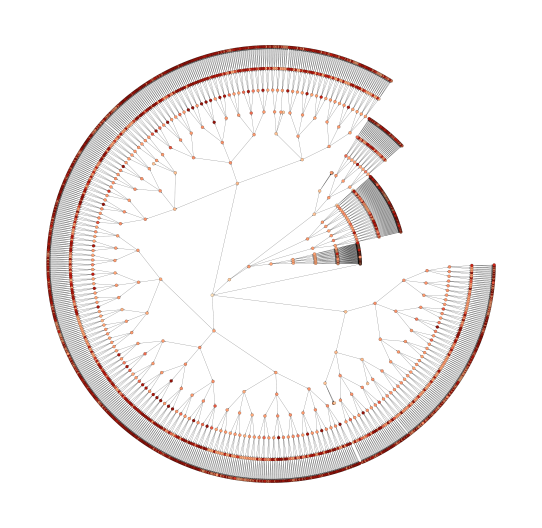